In [10]:
# models.ipynb

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from sklearn.metrics import classification_report

In [ ]:
# Ensure the project root is in the system path
project_root = os.path.abspath(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

num_classes = 26 # this is the only time this is defined 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define device 

In [13]:
# create the models
def create_model(model_type, num_classes):
    if model_type == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_type == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif model_type == "custom":
        model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        return model  # return early for the custom model
    else:
        raise ValueError("Invalid model type. Choose 'resnet18', 'resnet50', or 'custom'.")

    # change the last layer in ResNet models
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

In [ ]:
if __name__ == "__main__":
    num_classes = num_classes

    #  create finetunable ResNet18
    resnet18_model = create_model("resnet18", num_classes)
    print(resnet18_model)

    #  create ResNet50
    resnet50_model = create_model("resnet50", num_classes)
    print(resnet50_model)

    # create custom model
    custom_model = create_model("custom", num_classes)
    print(custom_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# train the models
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the same device (GPU)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training =
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # send to GPU

            
            optimizer.zero_grad()
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels)
            loss.backward() # back pass 
            optimizer.step()
            running_train_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # calculate training metrics
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # validation phase
        model.eval() # set to eval mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device) # to gpu
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# define custom dataset 
class CSVImageDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.labels = self.data.iloc[:, 0].values  # labels
        self.images = self.data.iloc[:, 1:].values  # all remaining columns are pixel values
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype('uint8')  # Reshape to 28x28
        label = self.labels[idx]
        
        # convert to PIL Image for transforms
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# define dataset path and transformations
train_csv_path = os.path.join(project_root, "Extracted_SignLanguageMNIST", "sign_mnist_train.csv")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reshape to fit ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize for RGB
])

# load dataset
dataset = CSVImageDataset(train_csv_path, transform=transform)

# traning/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# make dataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# training settings
num_epochs = 1
criterion = nn.CrossEntropyLoss()

results = {
    "resnet18": {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "report": None},
    "resnet50": {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "report": None},
    "custom": {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": [], "report": None},
}

models_to_train = {
    "resnet18": resnet18_model,
    "resnet50": resnet50_model,
    "custom": custom_model,
}

In [ ]:
for model_name, model in models_to_train.items():
    print(f"\nTraining {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
    )
    
    results[model_name]["train_losses"] = train_losses
    results[model_name]["val_losses"] = val_losses
    results[model_name]["train_accuracies"] = train_accuracies
    results[model_name]["val_accuracies"] = val_accuracies
    
    #  classification report
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    results[model_name]["report"] = classification_report(all_labels, all_preds, output_dict=True)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(all_labels, all_preds))



Training resnet18...
Epoch [1/1], Train Loss: 0.0266, Train Acc: 0.9925, Val Loss: 0.0001, Val Acc: 1.0000

Classification Report for resnet18:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       219
           1       1.00      1.00      1.00       188
           2       1.00      1.00      1.00       224
           3       1.00      1.00      1.00       252
           4       1.00      1.00      1.00       212
           5       1.00      1.00      1.00       259
           6       1.00      1.00      1.00       204
           7       1.00      1.00      1.00       194
           8       1.00      1.00      1.00       228
          10       1.00      1.00      1.00       242
          11       1.00      1.00      1.00       241
          12       1.00      1.00      1.00       218
          13       1.00      1.00      1.00       234
          14       1.00      1.00      1.00       240
          15       1.00      1.00      1.00

C:\Users\paige\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\paige\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\paige\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati


Classification Report for resnet50:

              precision    recall  f1-score   support

           0       1.00      0.47      0.64       219
           1       1.00      0.95      0.97       188
           2       1.00      1.00      1.00       224
           3       0.82      0.35      0.49       252
           4       0.70      1.00      0.82       212
           5       0.95      0.98      0.97       259
           6       0.96      0.95      0.96       204
           7       0.92      0.99      0.96       194
           8       0.69      0.94      0.80       228
          10       1.00      0.14      0.24       242
          11       0.86      0.98      0.92       241
          12       0.64      0.99      0.78       218
          13       1.00      0.62      0.77       234
          14       0.99      0.73      0.84       240
          15       1.00      0.93      0.96       231
          16       0.95      1.00      0.97       259
          17       0.22      1.00      0.37

In [ ]:
# save all the models as paths 
save_dir = os.path.join(project_root, "saved_models")
os.makedirs(save_dir, exist_ok=True)

for model_name, model in models_to_train.items():
    save_path = os.path.join(save_dir, f"trained_{model_name}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model {model_name} saved to {save_path}")

Model resnet18 saved to c:\Users\paige\OneDrive\Desktop\6147 - PYTORCH\Capstone_SignLanguageMNIST\saved_models\trained_resnet18.pth
Model resnet50 saved to c:\Users\paige\OneDrive\Desktop\6147 - PYTORCH\Capstone_SignLanguageMNIST\saved_models\trained_resnet50.pth
Model custom saved to c:\Users\paige\OneDrive\Desktop\6147 - PYTORCH\Capstone_SignLanguageMNIST\saved_models\trained_custom.pth


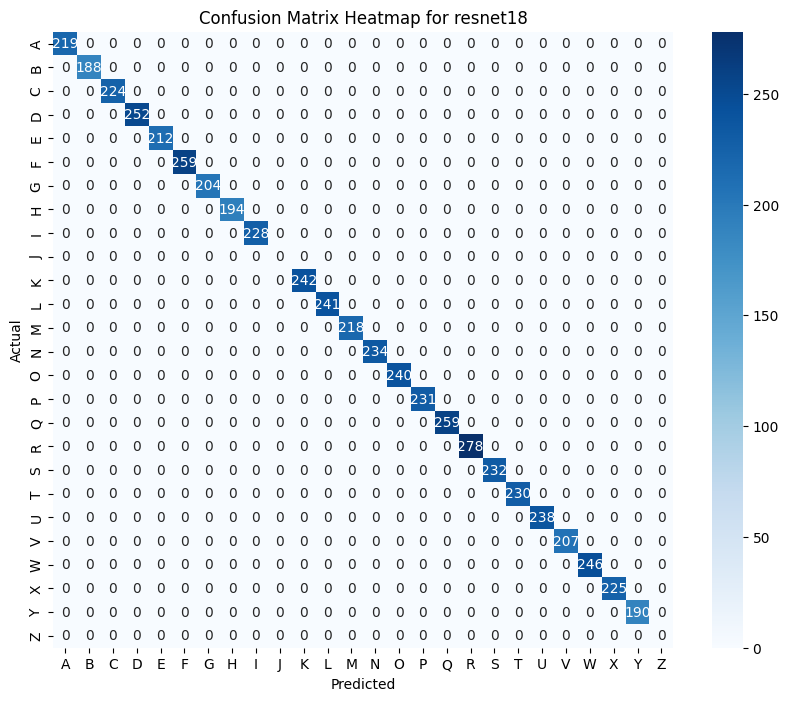

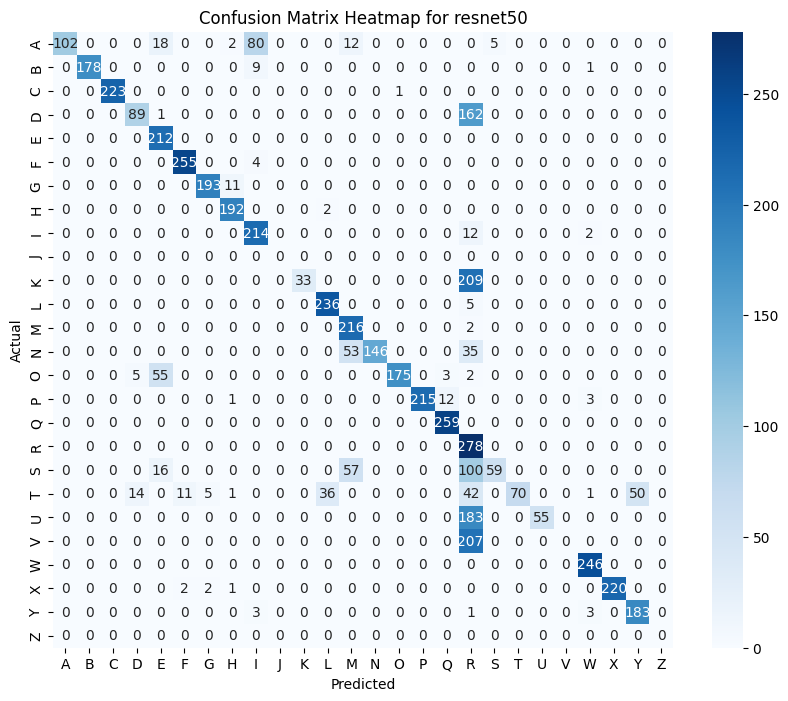

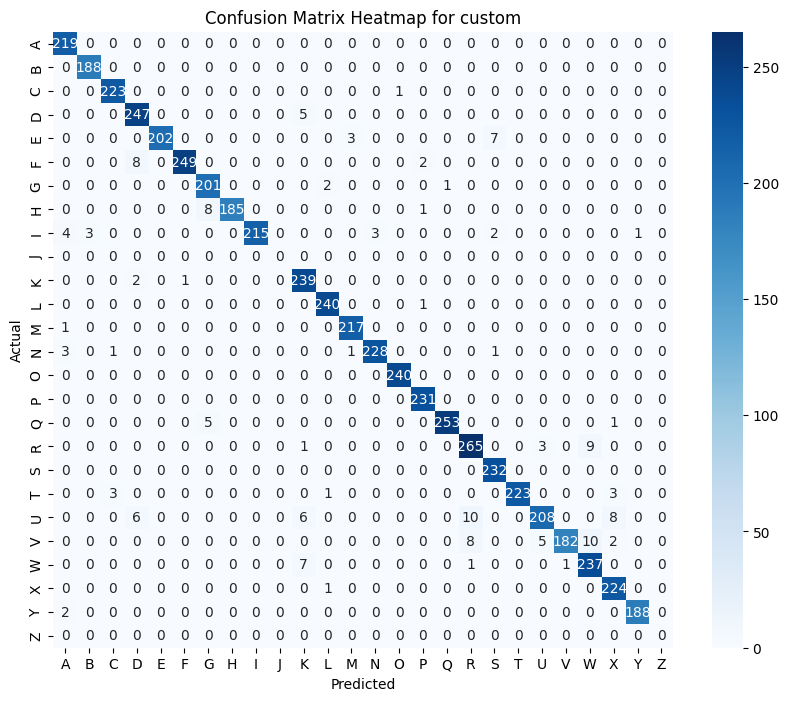

In [ ]:
# mapping for heatmap
classes = list(string.ascii_uppercase) 
class_labels = [letter for letter in classes]  
label_map = {letter: i for i, letter in enumerate(class_labels)}

# plot confusion matrices for each model with mapped labels 
confusion_matrices = {}
for model_name, model in models_to_train.items():
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # added in labels 
    all_labels = [class_labels[label] for label in all_labels]
    all_preds = [class_labels[pred] for pred in all_preds]
    
    # calculate confusion matrix
    confusion_matrix = pd.crosstab(
        pd.Series(all_labels, name="Actual"),
        pd.Series(all_preds, name="Predicted"),
        rownames=["Actual"],
        colnames=["Predicted"],
    )

    # show all classes 
    confusion_matrix = confusion_matrix.reindex(index=class_labels, columns=class_labels, fill_value=0)
    confusion_matrices[model_name] = confusion_matrix

# plot the confusion matrix heatmaps
for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix Heatmap for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

